In [1]:
import os
import seaborn as sns
from sklearn.metrics import confusion_matrix, f1_score, classification_report
from sklearn.model_selection import StratifiedKFold
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings("ignore", message=".*The 'nopython' keyword.*")
import shap
from pathlib import Path
import pandas as pd
from catboost import Pool, CatBoostClassifier
import mlflow
from dotenv import load_dotenv


load_dotenv(str(Path('../.env')))
remote_server_uri = os.getenv("MLFLOW_TRACKING_URI")
mlflow.set_tracking_uri(remote_server_uri)

In [2]:
train_path = Path('../data/processed/train_df.csv')
val_path = Path('../data/processed/val_df.csv')
test_path = Path('../data/processed/test_df.csv')

In [3]:
train_df = pd.read_csv(train_path)
val_df = pd.read_csv(val_path)
test_df = pd.read_csv(test_path)

In [4]:
train_pool = Pool(data=train_df.drop('target', axis=1), label=train_df['target'], text_features=['text'])
val_pool = Pool(data=val_df.drop('target', axis=1), label=val_df['target'], text_features=['text'])
test_pool = Pool(data=test_df.drop('target', axis=1), label=test_df['target'], text_features=['text'])

In [5]:
df = pd.concat([train_df, val_df, test_df], ignore_index=True)

In [6]:
# лучшие параметры после Optuna
cb_params = {
            'eval_metric': 'Logloss',
            'loss_function': 'Logloss',
            "task_type": "CPU",
            "border_count": 254,
            "grow_policy": "SymmetricTree",
            "boosting_type": "Plain",
            "random_seed": 7575,
            "iterations": 1000,
            'learning_rate': 0.44688251015940267,
            'depth': 4,
            'l2_leaf_reg': 1.3720330267414245,
            'random_strength': 0.7058520226446663,
            'bootstrap_type': 'Bernoulli',
            'min_data_in_leaf': 10,
            'subsample': 0.972912634760406
        }

In [7]:
X = df.drop('target', axis=1)
y = df['target']

scores = list()

kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=7575)
for i, (train_index, test_index) in enumerate(kf.split(X, y)):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

    train_dataset = Pool(data=X_train, label=y_train, text_features=['text'])
    eval_dataset = Pool(data=X_test, label=y_test, text_features=['text'])

    cb_classifier = CatBoostClassifier(**cb_params)
    cb_classifier.fit(train_dataset, eval_set=eval_dataset, verbose=False, early_stopping_rounds=100, use_best_model = True)

    preds = cb_classifier.predict(X_test)
    f1 = f1_score(y_test, preds, average='weighted')
    scores.append(f1)
    print(f'FOLD {i}, F1={f1}')


print()
print(f'F1 score:')
print(f'  Mean:{np.mean(scores, dtype="float16")}')
print(f'  Std:{np.std(scores, dtype="float16")}')

FOLD 0, F1=0.9298032603068646
FOLD 1, F1=0.9256902150865081
FOLD 2, F1=0.9334474104219103
FOLD 3, F1=0.9247925983262304
FOLD 4, F1=0.9243247675062133

F1 score:
  Mean:0.92724609375
  Std:0.003520965576171875


In [8]:
latest_staging_model_path = f"models:/tuned_catboost/None"
loaded_model = mlflow.catboost.load_model(latest_staging_model_path)

In [9]:
print('Train')
print(classification_report(train_df['target'], loaded_model.predict(train_df.drop('target', axis=1))))

Train
              precision    recall  f1-score   support

           0       0.97      0.97      0.97      3985
           1       0.97      0.97      0.97      3940

    accuracy                           0.97      7925
   macro avg       0.97      0.97      0.97      7925
weighted avg       0.97      0.97      0.97      7925



In [10]:
print('Val')
print(classification_report(val_df['target'], loaded_model.predict(val_df.drop('target', axis=1))))

Val
              precision    recall  f1-score   support

           0       0.91      0.90      0.90       704
           1       0.90      0.91      0.90       695

    accuracy                           0.90      1399
   macro avg       0.90      0.90      0.90      1399
weighted avg       0.90      0.90      0.90      1399



In [11]:
print('Test')
print(classification_report(test_df['target'], loaded_model.predict(test_df.drop('target', axis=1))))

Test
              precision    recall  f1-score   support

           0       0.89      0.89      0.89       828
           1       0.89      0.89      0.89       818

    accuracy                           0.89      1646
   macro avg       0.89      0.89      0.89      1646
weighted avg       0.89      0.89      0.89      1646



No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


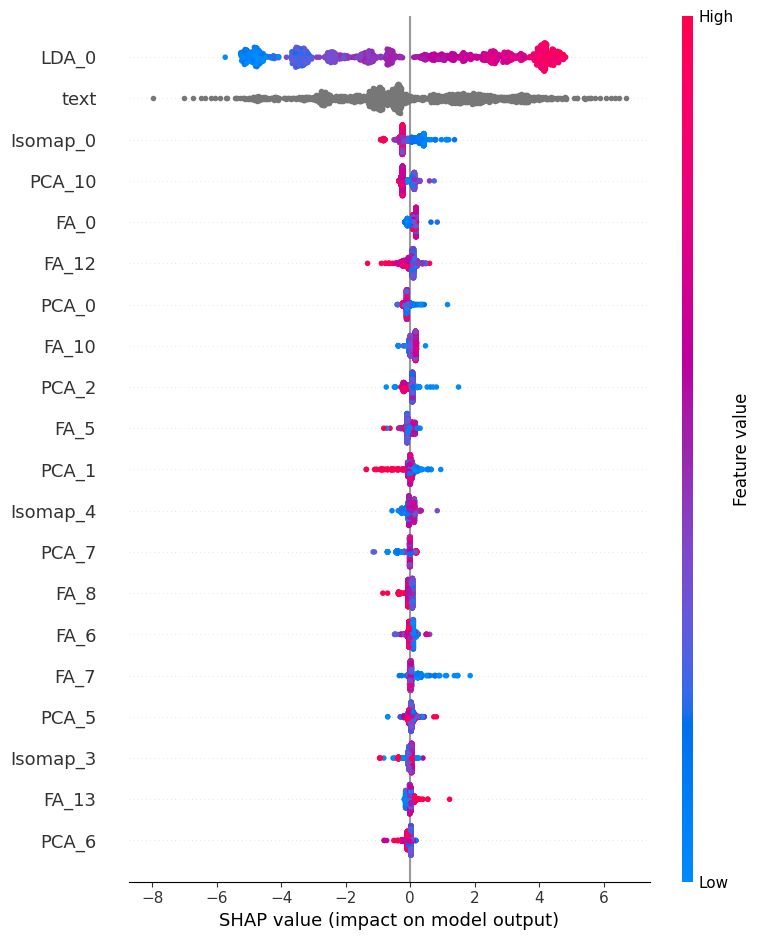

In [12]:
# Можем посмотреть влияние фичей на все классы
explainer = shap.TreeExplainer(loaded_model)

shap_values = explainer.shap_values(val_pool)
shap.summary_plot(shap_values, val_df.drop('target', axis=1))

In [15]:
loaded_model.get_feature_importance(prettified=True)

Feature Id  Importances
0       LDA_0    45.543698
1        text    39.456813
2       PCA_1     1.551430
3    Isomap_0     1.308050
4       FA_12     1.286571
5       PCA_5     0.948412
6    Isomap_4     0.729915
7       PCA_2     0.672604
8      PCA_14     0.668732
9    Isomap_3     0.658936
10       FA_7     0.628859
11       FA_3     0.568123
12       FA_5     0.528551
13       FA_6     0.510222
14      FA_13     0.468913
15     PCA_11     0.412999
16     PCA_10     0.394295
17      PCA_7     0.359749
18       FA_0     0.345166
19      PCA_6     0.318034
20      FA_14     0.314291
21      PCA_0     0.305821
22      PCA_4     0.296172
23       FA_8     0.276792
24      FA_10     0.240577
25       FA_4     0.221258
26     PCA_12     0.205048
27   Isomap_1     0.188530
28      PCA_3     0.164133
29       FA_9     0.139392
30   Isomap_2     0.122634
31     PCA_13     0.102125
32       FA_1     0.030613
33      FA_11     0.024851
34      PCA_8     0.007695
35      PCA_9     0.000000
36       FA_2     0.000000

Как мы видим, фичи из всех моделей для препроцессинга нашли себе место в топе фичей

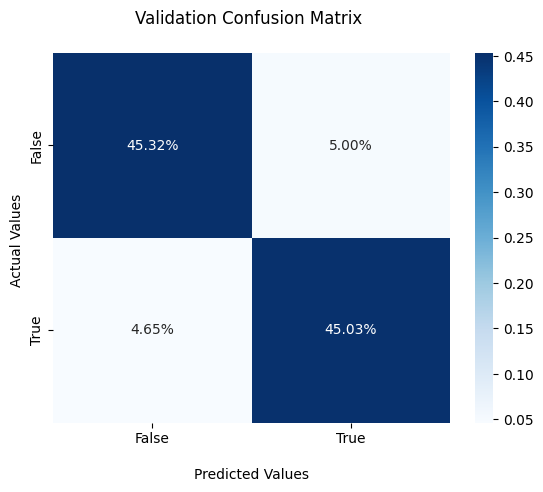

In [13]:
y_val = val_df['target']
y_pred = loaded_model.predict(val_df.drop('target', axis=1))

cf_matrix = confusion_matrix(y_val, y_pred)

fig, ax = plt.subplots(dpi=100)
sns.heatmap(cf_matrix/np.sum(cf_matrix), annot=True, fmt='.2%', cmap='Blues')

ax.set_title('Validation Confusion Matrix \n');
ax.set_xlabel('\nPredicted Values')
ax.set_ylabel('Actual Values ');

ax.xaxis.set_ticklabels(['False','True'])
ax.yaxis.set_ticklabels(['False','True'])


plt.show()

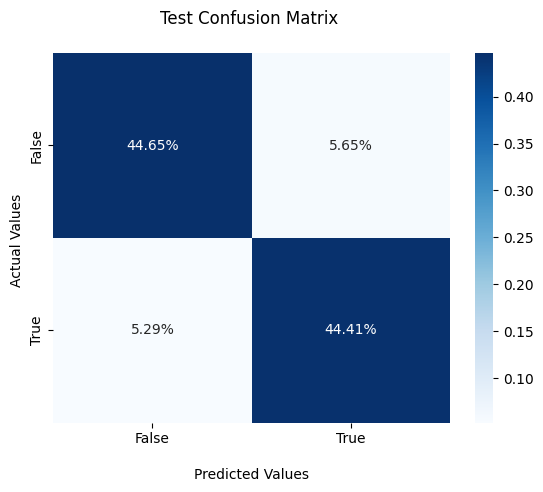

In [14]:
y_test = test_df['target']
y_pred = loaded_model.predict(test_df.drop('target', axis=1))

cf_matrix = confusion_matrix(y_test, y_pred)

fig, ax = plt.subplots(dpi=100)
sns.heatmap(cf_matrix/np.sum(cf_matrix), annot=True, fmt='.2%', cmap='Blues')

ax.set_title('Test Confusion Matrix \n');
ax.set_xlabel('\nPredicted Values')
ax.set_ylabel('Actual Values ');

ax.xaxis.set_ticklabels(['False','True'])
ax.yaxis.set_ticklabels(['False','True'])


plt.show()